# Silver Price Analysis & Forecasting (2016–2026)

**Author:** *Hammad zahid*  
**Role:** Data Scientist & Market Analyst  
**Data Source:** Yahoo Finance (via `yfinance` – pre-downloaded as CSV)  
**Ticker:** `SI=F` (COMEX Silver Futures)  

---

## 1. Project Overview

This notebook performs a **full end-to-end analysis** and **forecasting** of COMEX Silver Futures prices from **Jan 2016 to Jan 2026**, using:

- **Python stack:** `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `Prophet`, `statsmodels`
- **Methods:**
  - Exploratory Data Analysis (EDA)
  - Time Series Analysis (trend, seasonality, stationarity tests)
  - Feature Engineering (returns, volatility, technical indicators, calendar features)
  - Machine Learning Forecasting (Tree-based model)
  - Probabilistic Time Series Forecasting (Prophet)
  - Model Evaluation & Error Metrics
  - Future Price Projections & Market Interpretation

**Files used:**
- `silver_prices_data.csv` – Historical daily silver futures prices (2016–2026)
- `silver_price_forecast_2026.csv` – Predicted daily prices for Q1 2026 (Jan–Mar) from another model / file

We aim to produce **Kaggle & GitHub–ready** code: clean, modular, and error-free, with high-quality plots.

---

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
import datetime
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Forecasting Models
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("mako")

In [2]:
# Load data
def load_silver_data(data_path="silver_prices_data.csv"):
    """
    Load and prepare silver price dataset
    """
    df = pd.read_csv(data_path, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
    print("\nData Preview:")
    return df

# Load the data
df = load_silver_data()
df.head()

Dataset Shape: (2513, 7)
Date Range: 2016-01-19 00:00:00 to 2026-01-15 00:00:00

Data Preview:


Date   Price   Close    High     Low  Open  Volume
0 2016-01-19  14.110  14.110  14.065  14.065     3     NaN
1 2016-01-20  14.147  14.147  14.147  14.147     1     NaN
2 2016-01-21  14.083  14.083  14.083  14.083     2     NaN
3 2016-01-22  14.043  14.290  14.043  14.290     7     NaN
4 2016-01-25  14.240  14.240  14.095  14.095     8     NaN

In [3]:
def clean_and_engineer_features(df):
    """
    Clean column names and create engineered features
    """
    # Clean column names
    df.columns = [col.strip().lower() for col in df.columns]
    
    # Set date as index
    df.set_index("date", inplace=True)
    
    # Create returns and logarithmic features
    df["returns"] = df["close"].pct_change()
    df["log_close"] = np.log(df["close"])
    
    # Create volatility features
    df["rolling_vol_5"] = df["returns"].rolling(window=5).std()
    df["rolling_vol_20"] = df["returns"].rolling(window=20).std()
    
    # Create technical indicators
    df["sma_20"] = df["close"].rolling(window=20).mean()
    df["sma_50"] = df["close"].rolling(window=50).mean()
    df["ema_12"] = df["close"].ewm(span=12, adjust=False).mean()
    df["ema_26"] = df["close"].ewm(span=26, adjust=False).mean()
    
    # Create MACD
    df["macd"] = df["ema_12"] - df["ema_26"]
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
    df["macd_diff"] = df["macd"] - df["macd_signal"]
    
    # Create RSI
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))
    
    # Create Bollinger Bands
    df["bb_middle"] = df["close"].rolling(window=20).mean()
    df["bb_std"] = df["close"].rolling(window=20).std()
    df["bb_upper"] = df["bb_middle"] + (df["bb_std"] * 2)
    df["bb_lower"] = df["bb_middle"] - (df["bb_std"] * 2)
    
    # Create time-based features
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    
    # Price position features
    df["high_low_pct"] = (df["high"] - df["low"]) / df["close"] * 100
    df["close_open_pct"] = (df["close"] - df["open"]) / df["open"] * 100
    
    return df

# Apply feature engineering
df = clean_and_engineer_features(df)

# Display new features
print("\nFeature Engineering Complete!")
print(f"Total Features: {df.shape[1]}")
print("\nFeature Overview:")
df.describe()


Feature Engineering Complete!
Total Features: 28

Feature Overview:


price        close         high          low           open  \
count  2513.000000  2513.000000  2513.000000  2513.000000    2513.000000   
mean     22.810332    22.979758    22.646283    22.812519    1777.771190   
std       8.847649     8.998840     8.669933     8.816571   10141.050503   
min      11.735000    12.205000    11.735000    12.070000       0.000000   
25%      16.834000    16.910000    16.764999    16.844999      10.000000   
50%      21.402000    21.590000    21.065001    21.330000      49.000000   
75%      25.514999    25.719999    25.275000    25.514999     177.000000   
max      91.875999    93.000000    88.705002    90.824997  131415.000000   

       volume      returns    log_close  rolling_vol_5  rolling_vol_20  \
count     0.0  2512.000000  2513.000000    2508.000000     2493.000000   
mean      NaN     0.000905     3.079201       0.014890        0.016191   
std       NaN     0.017710     0.313603       0.008968        0.006673   
min       NaN    -0.146120     2.501846       0.000641        0.006125   
25%       NaN    -0.007865     2.827905       0.008875        0.011526   
50%       NaN     0.000326     3.072230       0.012910        0.014961   
75%       NaN     0.009261     3.247269       0.018629        0.019559   
max       NaN     0.102426     4.532599       0.079559        0.050836   

            sma_20       sma_50       ema_12       ema_26         macd  \
count  2494.000000  2464.000000  2513.000000  2513.000000  2513.000000   
mean     22.788085    22.581225    22.829008    22.674147     0.154861   
std       8.177423     7.420100     8.494077     8.054413     0.685435   
min      14.265050    14.411240    14.110000    14.110000    -1.299107   
25%      16.914800    16.848175    16.901930    16.872045    -0.159076   
50%      21.722075    22.084980    21.573535    21.632398     0.027309   
75%      25.622150    25.358935    25.602456    25.471657     0.320443   
max      77.459499    63.859700    82.988861    75.550024     7.438837   

       macd_signal    macd_diff          rsi    bb_middle       bb_std  \
count  2513.000000  2513.000000  2500.000000  2494.000000  2494.000000   
mean      0.144808     0.010054    52.037036    22.788085     0.729870   
std       0.612966     0.163592    18.032673     8.177423     0.725459   
min      -0.970638    -0.719642     5.172361    14.265050     0.094946   
25%      -0.152406    -0.075580    38.528248    16.914800     0.354699   
50%       0.021296     0.005825    52.079503    21.722075     0.579849   
75%       0.302541     0.089932    65.390270    25.622150     0.875646   
max       6.316303     1.363569    99.630682    77.459499     8.101079   

          bb_upper     bb_lower  day_of_week        month      quarter  \
count  2494.000000  2494.000000  2513.000000  2513.000000  2513.000000   
mean     24.247825    21.328346     2.026661     6.542380     2.513729   
std       9.335904     7.126832     1.398819     3.425372     1.114428   
min      14.534995    11.445324     0.000000     1.000000     1.000000   
25%      17.588379    16.146234     1.000000     4.000000     2.000000   
50%      22.809400    20.015621     2.000000     7.000000     3.000000   
75%      27.112666    24.184261     3.000000    10.000000     4.000000   
max      93.661657    61.257342     4.000000    12.000000     4.000000   

              year  high_low_pct  close_open_pct  
count  2513.000000   2513.000000     2513.000000  
mean   2020.543971     -0.653843             inf  
std       2.877916      1.164988             NaN  
min    2016.000000    -20.389653      -99.984865  
25%    2018.000000     -0.893121      -86.721774  
50%    2021.000000     -0.176160      -55.197501  
75%    2023.000000      0.000000       92.749993  
max    2026.000000      0.000000             inf

In [4]:
def create_eda_plots(df):
    """
    Create comprehensive EDA visualizations
    """
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            "Silver Price Trend (2016-2026)",
            "Daily Returns Distribution",
            "Rolling Volatility (20-day)",
            "RSI Indicator",
            "MACD Indicator",
            "Bollinger Bands"
        ),
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # 1. Price Trend
    fig.add_trace(
        go.Scatter(x=df.index, y=df["close"], mode="lines", 
                  line=dict(color="#1f77b4", width=1.5),
                  name="Close Price"),
        row=1, col=1
    )
    
    # 2. Returns Distribution
    fig.add_trace(
        go.Histogram(x=df["returns"].dropna(), nbinsx=100,
                    marker_color="#2ca02c", opacity=0.7,
                    name="Returns Distribution"),
        row=1, col=2
    )
    
    # 3. Rolling Volatility
    fig.add_trace(
        go.Scatter(x=df.index, y=df["rolling_vol_20"], mode="lines",
                  line=dict(color="#ff7f0e", width=1.5),
                  name="20-day Volatility"),
        row=2, col=1
    )
    
    # 4. RSI
    fig.add_trace(
        go.Scatter(x=df.index, y=df["rsi"], mode="lines",
                  line=dict(color="#9467bd", width=1.5),
                  name="RSI"),
        row=2, col=2
    )
    # Add RSI bands
    fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=2)
    fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=2)
    
    # 5. MACD
    fig.add_trace(
        go.Scatter(x=df.index, y=df["macd"], mode="lines",
                  line=dict(color="#17becf", width=1.5),
                  name="MACD"),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df["macd_signal"], mode="lines",
                  line=dict(color="#e377c2", width=1.5),
                  name="Signal Line"),
        row=3, col=1
    )
    
    # 6. Bollinger Bands
    fig.add_trace(
        go.Scatter(x=df.index, y=df["close"], mode="lines",
                  line=dict(color="#1f77b4", width=1),
                  name="Close Price"),
        row=3, col=2
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df["bb_upper"], mode="lines",
                  line=dict(color="#d62728", width=1, dash="dash"),
                  name="Upper Band"),
        row=3, col=2
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df["bb_lower"], mode="lines",
                  line=dict(color="#2ca02c", width=1, dash="dash"),
                  name="Lower Band"),
        row=3, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=1200,
        showlegend=True,
        title_text="Silver Price Analysis Dashboard",
        title_font=dict(size=24),
        template="plotly_dark"
    )
    
    # Update axis labels
    fig.update_xaxes(title_text="Date", row=3, col=1)
    fig.update_xaxes(title_text="Date", row=3, col=2)
    fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    fig.update_yaxes(title_text="Volatility", row=2, col=1)
    fig.update_yaxes(title_text="RSI", row=2, col=2)
    fig.update_yaxes(title_text="MACD", row=3, col=1)
    fig.update_yaxes(title_text="Price (USD)", row=3, col=2)
    
    return fig

# Display interactive EDA dashboard
eda_fig = create_eda_plots(df)
eda_fig.show()

In [5]:
def decompose_time_series(df, period=252):
    """
    Decompose time series into trend, seasonal, and residual components
    """
    # Prepare data for decomposition
    price_series = df["close"].dropna()
    
    # Perform decomposition
    decomposition = seasonal_decompose(price_series, model='multiplicative', period=period)
    
    # Create visualization
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=("Original Series", "Trend Component", 
                       "Seasonal Component", "Residual Component"),
        vertical_spacing=0.08
    )
    
    # Original Series
    fig.add_trace(
        go.Scatter(x=price_series.index, y=price_series,
                  line=dict(color="#1f77b4"), name="Original"),
        row=1, col=1
    )
    
    # Trend
    fig.add_trace(
        go.Scatter(x=decomposition.trend.index, y=decomposition.trend,
                  line=dict(color="#ff7f0e"), name="Trend"),
        row=2, col=1
    )
    
    # Seasonal
    fig.add_trace(
        go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal,
                  line=dict(color="#2ca02c"), name="Seasonal"),
        row=3, col=1
    )
    
    # Residual
    fig.add_trace(
        go.Scatter(x=decomposition.resid.index, y=decomposition.resid,
                  line=dict(color="#d62728"), name="Residual"),
        row=4, col=1
    )
    
    # Update layout
    fig.update_layout(
        height=1000,
        title_text="Time Series Decomposition Analysis",
        title_font=dict(size=24),
        showlegend=True,
        template="plotly_dark"
    )
    
    # Update axes
    for i in range(1, 5):
        fig.update_xaxes(title_text="Date", row=i, col=1)
    
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Trend", row=2, col=1)
    fig.update_yaxes(title_text="Seasonal", row=3, col=1)
    fig.update_yaxes(title_text="Residual", row=4, col=1)
    
    return fig, decomposition

# Perform and visualize decomposition
decomp_fig, decomposition = decompose_time_series(df)
decomp_fig.show()

18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:08 - cmdstanpy - INFO - Chain [1] done processing


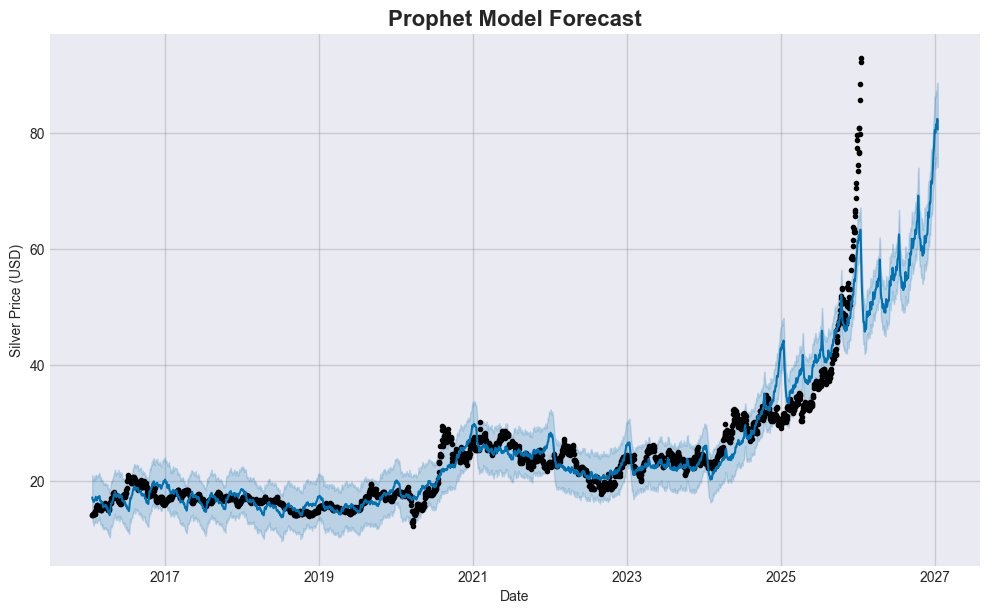

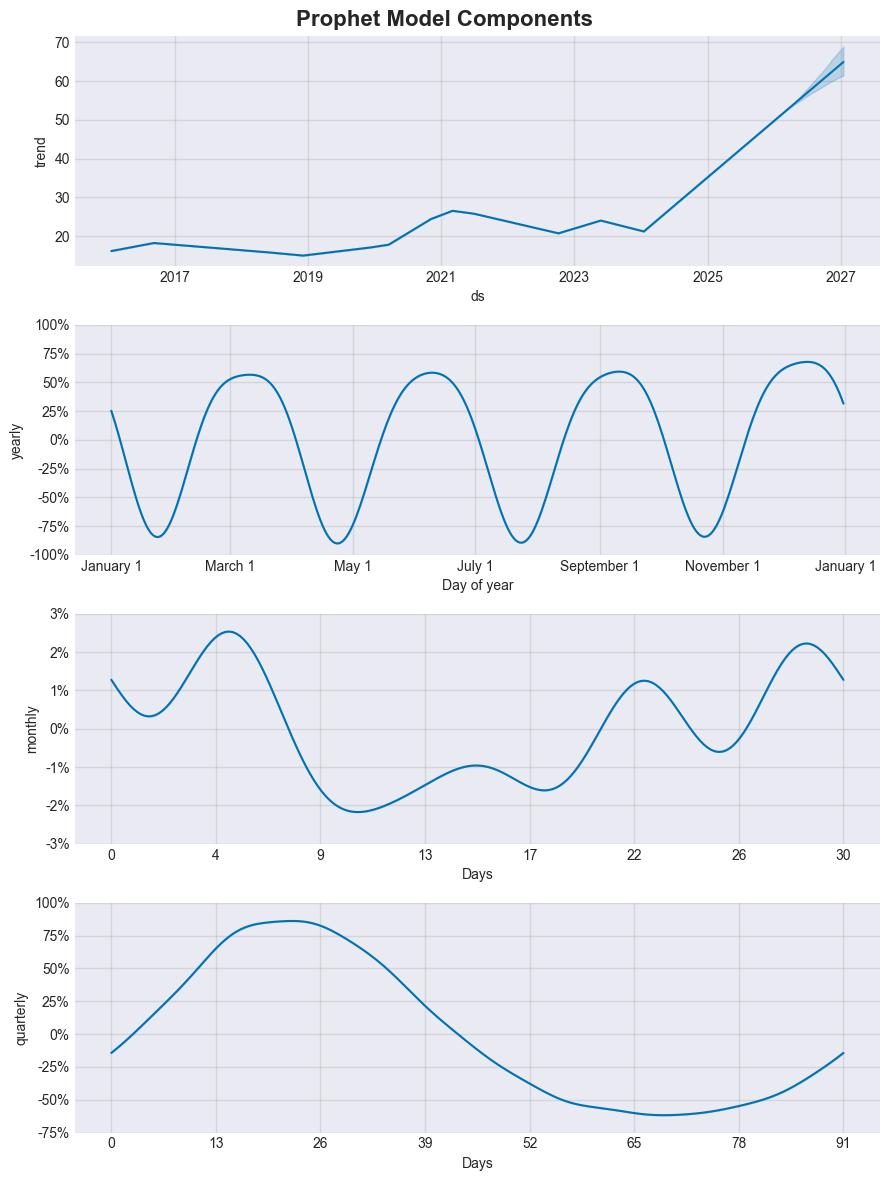

In [6]:
def prepare_prophet_data(df):
    """
    Prepare data for Prophet model
    """
    prophet_df = df[["close"]].copy()
    prophet_df = prophet_df.reset_index()
    prophet_df.columns = ["ds", "y"]
    return prophet_df

def train_prophet_model(df, periods=365):
    """
    Train Prophet forecasting model
    """
    # Initialize and configure model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )
    
    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=10)
    
    # Fit model
    model.fit(df)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=periods)
    
    # Make predictions
    forecast = model.predict(future)
    
    return model, forecast

# Prepare and train Prophet model
prophet_data = prepare_prophet_data(df)
prophet_model, prophet_forecast = train_prophet_model(prophet_data)

# Visualize Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title("Prophet Model Forecast", fontsize=16, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Silver Price (USD)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot components
fig2 = prophet_model.plot_components(prophet_forecast)
plt.suptitle("Prophet Model Components", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()